# Train - Dev - Test Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
##############################################################################
##########                DATABASE FUNCTIONS                     #############
##############################################################################
#### Read function to import data from the SQL to a pandas dataframe.
def readSQL(query):
    import pandas as pd
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    df = pd.read_sql_query(query, db)
    db.close()
    return(df)

#### Write a pandas dataframe into an SQL table. Use overwrite=True if you want to delete 
#### first a pre-existent table with the same name. Use append=True if you want to append
#### the data in the dataframe to a pre-existent table.
def writeSQL(df,tablename,overwrite=False, append=False):
    import pandas as pd
    import sqlite3 as sql
    db = sql.connect(DB_FILE)
    if (overwrite):
        action = "replace"
    elif (append):
        action = "append"
    else: 
        action = "fail"
    df.to_sql(tablename, db, if_exists=action)
    db.close()


In [3]:
import os
cwd = os.getcwd()
DB_FILE = "%s\Data\loans.db" % cwd

In [5]:
loans = readSQL('''SELECT * FROM full_dataset''')

In [6]:
loans.head()

,index,initial_list_status,loan_amnt,funded_amnt,funded_amnt_inv,term,annual_inc,dti,delinq_2yrs,acc_now_delinq,...,cat_delinq_2yrs_zero,cat_inq_last_6mths_more than 2,cat_inq_last_6mths_one,cat_inq_last_6mths_zero,inc_grp_high_inc,inc_grp_low_inc,inc_grp_middle_inc,inc_grp_veryhigh_inc,credit_hist_grp_4-13_yrs,default
0,0,1,10000,10000,2175.00,0,36400.0,18.92,0,0,...,1,0,1,0,0,0,0,0,1,0
1,1,1,5400,5400,375.00,0,42000.0,16.09,0,0,...,1,0,0,1,0,0,0,0,1,0
2,2,1,1500,1500,583.05,0,15600.0,14.23,0,0,...,1,1,0,0,0,0,0,0,1,0
3,3,1,4800,4800,1550.00,0,60000.0,12.94,0,0,...,1,1,0,0,0,1,0,0,1,0
4,4,1,4800,4800,1625.00,0,25000.0,18.19,1,0,...,0,0,0,1,0,0,0,0,1,0


In [7]:
loans = loans.drop(["index"],axis=1)

In [52]:
df = loans.copy()

In [53]:
## check the dtypes on the dataframe
df.dtypes

initial_list_status                     object
loan_amnt                                int64
funded_amnt                              int64
funded_amnt_inv                        float64
term                                    object
annual_inc                             float64
dti                                    float64
delinq_2yrs                              int64
acc_now_delinq                          object
inq_last_6mths                           int64
open_acc                                 int64
revol_bal                              float64
revol_util                             float64
total_acc                                int64
loan_installment                       float64
acc_ratio                              float64
credit_hist                              int64
poverty_rate_p                         float64
cat_collections_12_mths_ex_med          object
open_acc_rt                            float64
total_acc_rt                           float64
annual_inc_lo

We have to define some of the variables to be sure they are used as required by the models

In [54]:
##Get Series of columns
cat_vars = list(df.select_dtypes(include=['object']).columns)
cat_vars
##Turn
for column in cat_vars:
    df[column] = df[column].astype('category')

In [55]:
### check missings
df.isnull().sum()

initial_list_status                    0
loan_amnt                              0
funded_amnt                            0
funded_amnt_inv                        0
term                                   0
annual_inc                             0
dti                                    0
delinq_2yrs                            0
acc_now_delinq                         0
inq_last_6mths                         0
open_acc                               0
revol_bal                              0
revol_util                             0
total_acc                              0
loan_installment                       0
acc_ratio                              0
credit_hist                            0
poverty_rate_p                         0
cat_collections_12_mths_ex_med         0
open_acc_rt                            0
total_acc_rt                           0
annual_inc_log                         0
annual_inc_rt                          0
revol_bal_rt                           0
credit_hist_log 

## Preparing the partition to test, train and dev

In [56]:
from random import seed, shuffle,randint
##Get Thomas Library
import pyMechkar as mechkar
import time


In [57]:
def splittDF(df):
    p_value = 1
    vn = df.columns.tolist()
    while p_value > 0: 
        randomSeed = randint(100,2000)
        print (randomSeed)
        seed(randomSeed)
        xind = [i for i in range(len(df))]
        shuffle(xind,)
        ### We will split as follows: 10% test, 10% dev and 80% train
        ### test split
        split_1 = int(0.1 * len(xind))
        ### train-dev split
        split_2 = int(0.2 * len(xind))
        df['dataset'] = "train"
        df.iloc[xind[0:split_1],79] = "test"
        df.iloc[xind[split_1:split_2],79] = "dev"
        df['dataset'] = df['dataset'].astype('category')
        init = time.time()
        tab1 = mechkar.pyMechkar().Table1(x=vn,y="dataset",data=df,categorize=True,maxcat=7)
        print("---- %s seconds -----" % (time.time() - init))
        t = tab1.loc[(tab1['p_value']<0.05),]
        p_value = len(t.index)
    return(df)

In [58]:
df = splittDF(df)

412
Factorizing... please wait
*******************************************************************************
[]
[********************************************************************************
[********************************************************************************
[********************************************************************************
['Unable to calcualte the Fisher exact test for variables acc_now_delinq and dataset... The p-value may be incorrect']
------ Finished in 184.38098573684692econds -----
---- 184.38098573684692 seconds -----
478
Factorizing... please wait
*******************************************************************************
[]
[********************************************************************************
[********************************************************************************
[********************************************************************************
['Unable to calcualte the Fisher exact test for variables acc_now_delinq 

In [59]:
##SEED=1207 Gave us the balanced split
df.head()

,initial_list_status,loan_amnt,funded_amnt,funded_amnt_inv,term,annual_inc,dti,delinq_2yrs,acc_now_delinq,inq_last_6mths,...,cat_inq_last_6mths_more than 2,cat_inq_last_6mths_one,cat_inq_last_6mths_zero,inc_grp_high_inc,inc_grp_low_inc,inc_grp_middle_inc,inc_grp_veryhigh_inc,credit_hist_grp_4-13_yrs,default,dataset
0,1,10000,10000,2175.00,0,36400.0,18.92,0,0,1,...,0,1,0,0,0,0,0,1,0,train
1,1,5400,5400,375.00,0,42000.0,16.09,0,0,0,...,0,0,1,0,0,0,0,1,0,train
2,1,1500,1500,583.05,0,15600.0,14.23,0,0,4,...,1,0,0,0,0,0,0,1,0,train
3,1,4800,4800,1550.00,0,60000.0,12.94,0,0,3,...,1,0,0,0,1,0,0,1,0,train
4,1,4800,4800,1625.00,0,25000.0,18.19,1,0,0,...,0,0,1,0,0,0,0,1,0,train


In [61]:
### We will split as follows: 10% test, 10% dev and 80% train
X_test =  df.loc[(df["dataset"] =="test"),] #power.iloc[xind[0:split_1],]
y_test = df.loc[(df["dataset"] =="test"),"default"]#power.iloc[xind[0:split_1],29]

X_dev = df.loc[(df["dataset"] =="dev"),]#power.iloc[xind[split_1:split_2],]
y_dev = df.loc[(df["dataset"] =="dev"),"default"]#power.iloc[xind[split_1:split_2],29]

X_train = df.loc[(df["dataset"] =="train"),]#power.iloc[xind[split_2:],]
y_train = df.loc[(df["dataset"] =="train"),"default"]#power.iloc[xind[split_2:],29]


In [62]:
print(X_train.shape)
print(y_train.shape)

print(X_dev.shape)
print(y_dev.shape)

print(X_test.shape)
print(y_test.shape)


(203836, 80)
(203836,)
(25479, 80)
(25479,)
(25479, 80)
(25479,)


In [63]:
X_train.head()

,initial_list_status,loan_amnt,funded_amnt,funded_amnt_inv,term,annual_inc,dti,delinq_2yrs,acc_now_delinq,inq_last_6mths,...,cat_inq_last_6mths_more than 2,cat_inq_last_6mths_one,cat_inq_last_6mths_zero,inc_grp_high_inc,inc_grp_low_inc,inc_grp_middle_inc,inc_grp_veryhigh_inc,credit_hist_grp_4-13_yrs,default,dataset
0,1,10000,10000,2175.00,0,36400.0,18.92,0,0,1,...,0,1,0,0,0,0,0,1,0,train
1,1,5400,5400,375.00,0,42000.0,16.09,0,0,0,...,0,0,1,0,0,0,0,1,0,train
2,1,1500,1500,583.05,0,15600.0,14.23,0,0,4,...,1,0,0,0,0,0,0,1,0,train
3,1,4800,4800,1550.00,0,60000.0,12.94,0,0,3,...,1,0,0,0,1,0,0,1,0,train
4,1,4800,4800,1625.00,0,25000.0,18.19,1,0,0,...,0,0,1,0,0,0,0,1,0,train


In [64]:
print(y_train.describe())
print(y_train.isnull().sum())

count     203836
unique         2
top            0
freq      167067
Name: default, dtype: object
0


In [65]:
## drop default from X_xxx
X_train = X_train.drop('default',axis=1)
X_dev = X_dev.drop('default',axis=1)
X_test = X_test.drop('default',axis=1)

Check the splited datasets distributions

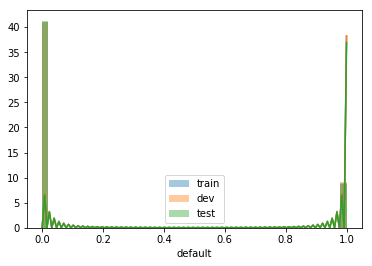

In [75]:
sns.distplot(y_train.astype(int),label="train")
sns.distplot(y_dev.astype(int),label="dev")
sns.distplot(y_test.astype(int),label="test")
plt.legend()
plt.show()

In [76]:
X_train = X_train.drop('dataset',axis=1)
X_dev = X_dev.drop('dataset',axis=1)
X_test = X_test.drop('dataset',axis=1)

Save the 3 datasets

In [140]:
writeSQL(X_train,tablename="X_train")
writeSQL(X_dev,tablename="X_dev")
writeSQL(X_test,tablename="X_test")
writeSQL(y_train,tablename="Y_train")
writeSQL(y_dev,tablename="Y_dev")
writeSQL(y_test,tablename="Y_test")

C:\Users\Kobi\Anaconda3\lib\site-packages\pandas\core\generic.py:2127: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)
C:\Users\Kobi\Anaconda3\lib\site-packages\pandas\core\generic.py:2127: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)
C:\Users\Kobi\Anaconda3\lib\site-packages\pandas\core\generic.py:2127: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


We need to scale the numeric columns of our datasets

In [4]:
X_Train = readSQL('''SELECT * FROM X_train''')

In [5]:
X_Dev = readSQL('''SELECT * FROM X_dev''')

In [6]:
X_Test = readSQL('''SELECT * FROM X_test''')

In [7]:
numerical = X_Train.columns[(X_Train.dtypes == 'float64')].tolist()

In [8]:
numerical

['funded_amnt_inv',
 'annual_inc',
 'dti',
 'acc_now_delinq',
 'revol_bal',
 'revol_util',
 'loan_installment',
 'acc_ratio',
 'poverty_rate_p',
 'cat_collections_12_mths_ex_med',
 'open_acc_rt',
 'total_acc_rt',
 'annual_inc_log',
 'annual_inc_rt',
 'revol_bal_rt',
 'credit_hist_log',
 'credit_hist_rt']

In [9]:
numerical.extend(['loan_amnt', 'funded_amnt','delinq_2yrs','inq_last_6mths', 'open_acc', 'total_acc','credit_hist'])

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_Train[numerical] = sc.fit_transform(X_Train[numerical])
X_Dev[numerical] = sc.fit_transform(X_Dev[numerical])
X_Test[numerical] = sc.fit_transform(X_Test[numerical])

In [ ]:
X_Train = X_Train.drop('level_0',axis=1)
X_Dev = X_Dev.drop('level_0',axis=1)
X_Test = X_Test.drop('level_0',axis=1)

In [12]:
writeSQL(X_Train,tablename="X_train_scaled")
writeSQL(X_Dev,tablename="X_dev_scaled")
writeSQL(X_Test,tablename="X_test_scaled")